### Notebook that probes that missense mutations in degrons significantly stabilize the proteins using TCGA data and MS
- Figure 3d all mutations in degrons (CNA<=1)
- Figure 3e, classified by level of confidence (CNA<=1)


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats

### paths

In [2]:
base="../../" 


dataset_ms_irls = os.path.join(base,"data/ms_matched_irls.tsv.gz")
path_output_missense_degrons_ms= os.path.join(base,"data","missense_clean_type_ms.tsv.gz")
path_output_indels_degrons_ms = os.path.join(base,"data","indels_clean_type_ms.tsv.gz")


output_path_plots = os.path.join(base,"plots/Figure3/")

# Load MS information from TCGA

In [3]:
df_missense_raw = pd.read_csv(path_output_missense_degrons_ms,sep="\t",compression="gzip")
df_all_rppa = pd.read_csv(dataset_ms_irls,sep="\t",compression="gzip")

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Filter both datasets 
- Remove Samples with alteractions upstream E3ligase
- high-level amplifications/deletions
- mutations that disrupt the epitope and desestabilizes the protein
- remove TP53 for the analysis 

In [4]:
# Raw data
df_missense_raw = pd.read_csv(path_output_missense_degrons_ms,sep="\t",compression="gzip")
df_indels_raw = pd.read_csv(path_output_indels_degrons_ms,sep="\t",compression="gzip")
df_all_rppa = pd.read_csv(dataset_ms_irls,sep="\t",compression="gzip")
phenotypes = ["In_Frame_Altering_Motif","In_Frame_Altering_Flanking_Degron"]
# Prepare the datasets 
# Wild type
df_wt = df_all_rppa[(df_all_rppa["Phenotype"]=="WT")&(df_all_rppa["CNA"]<=1)&(df_all_rppa["CNA"]>=-1)&(df_all_rppa["Hugo_Symbol"]!="TP53")&(~df_all_rppa["Altered_E3_Ligases"])]
df_wt["Type"] = "WT"
df_wt["DEGRON"] ="-"
df_wt["Class"] = "NON-DEGRON"
df_wt["Prob_DEGRON"] = 0.0 
df_wt["Annotated"] = "NO" 
# Other alterations
# Missense
df_missense_other = df_missense_raw[(df_missense_raw["Type_Missense"]=="Other_Missense")&(df_missense_raw["CNA"]<=1)&(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])]
df_missense_other["Type"] = "Other_Alterations"
# Indels
df_indels_other = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"]=="Other_In_Frame")&(df_indels_raw["Phenotype"].str.contains("In_Frame"))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])]
df_indels_other["Type"] = "Other_Alterations"
# Alterations degron

# missense
df_missense_degron= df_missense_raw[(df_missense_raw["Type_Missense"]=="Mutation_Altering_Motif")&(df_missense_raw["Phenotype"]=="Missense_Mutation")&(df_missense_raw["CNA"]<=1)&(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])]
df_missense_degron["Type"] = "Alteration_Degron"
# indel
df_indels_degron = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"].isin(phenotypes))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])]
df_indels_degron["Type"] = "Alteration_Degron"

# ALterations PTM

df_missense_ptm = df_missense_raw[(df_missense_raw["Type_Missense"]=="Mutation_Flanking_PTM")&(df_missense_raw["Phenotype"]=="Missense_Mutation")&(df_missense_raw["CNA"]<=1)&(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])]
df_missense_ptm["Type"] = "Alteration_Degron_PTM"
# indel
df_indels_ptm = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"].str.contains("In_Frame_Altering_PTM_Flanking"))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])]
df_indels_ptm["Type"] = "Alteration_Degron_PTM"


columns = ["Type","Stability_Change","Phenotype","Matchable_Sample_ID","Hugo_Symbol","Prob_DEGRON","DEGRON","Class","Annotated"]


df_total = pd.concat([df_wt[columns],df_missense_other[columns],df_indels_other[columns],df_missense_degron[columns],df_indels_degron[columns],df_missense_ptm[columns],df_indels_ptm[columns]])


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [5]:
df_total["Type"].unique()

array(['WT', 'Other_Alterations', 'Alteration_Degron',
       'Alteration_Degron_PTM'], dtype=object)

### Visualize the categories

Sample size: 10 1223 1615609


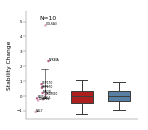

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(2, 2.)
size_strip = 3
p = {"Other_Alterations":"#cc0000","Alteration_Degron":"white","WT":"#4682B4","Alteration_Degron_PTM":"#6FBC5F"}
s = ["Alteration_Degron","Other_Alterations","WT"]
data = df_total[(((df_total["Type"].isin(["Alteration_Degron"]))&(df_total["Prob_DEGRON"]>0.5))|(df_total["Phenotype"]=="WT")|(df_total["Type"]=="Other_Alterations"))]

# Plot Points for mutations altering Motif
# Missense mutations
#g = sns.stripplot(data=data[(data["Type"]=="Alteration_Degron")&(data["Phenotype"]=="Missense_Mutation")&(data["Class"]!="DEGRON")],x="Type",y="Stability_Change",order=s,alpha=0.7,size=size_strip,palette={"Alteration_Degron":"#d98cb3","Other_Alterations":"#cc0000","WT":"#4682B4","Alteration_Degron_PTM":"#6FBC5F"},jitter=True,dodge=True)
#g = sns.stripplot(data=data[(data["Type"]=="Alteration_Degron")&(data["Phenotype"]=="Missense_Mutation")&(data["Class"]=="DEGRON")&(data["Annotated"]=="NO")],x="Type",y="Stability_Change",order=s,alpha=0.7,size=size_strip,palette={"Alteration_Degron":"#ac3973","Other_Alterations":"#cc0000","WT":"#4682B4","Alteration_Degron_PTM":"#6FBC5F"},jitter=True,dodge=True)
#g = sns.stripplot(data=data[(data["Type"]=="Alteration_Degron")&(data["Phenotype"]=="Missense_Mutation")&(data["Class"]=="DEGRON")&(data["Annotated"]=="YES")],x="Type",y="Stability_Change",order=s,alpha=0.7,size=size_strip,palette={"Alteration_Degron":"#ac3973","Other_Alterations":"#cc0000","WT":"#4682B4","Alteration_Degron_PTM":"#6FBC5F"},jitter=True,dodge=True,edgecolor='gray',linewidth=1)
# Jitter
ys=data[(data["Type"]=="Alteration_Degron")]["Stability_Change"].values
types=data[(data["Type"]=="Alteration_Degron")]["Class"].values
hugos = data[(data["Type"]=="Alteration_Degron")]["Hugo_Symbol"].values
xs = []
colors = []
for i in range(len(ys)):
    xs.append(np.random.uniform(low=-0.25,high=0.25) )
    if types[i] == "DEGRON":
        colors.append("#ac3973")
    else:
        colors.append("#d98cb3")


ax.scatter(x=xs,y=ys,color=colors,alpha=0.8,linewidths=0.0,s=size_strip+3)
for i in range(len(ys)):
    ax.annotate(xy=(xs[i]+0.01,ys[i]+0.02),s=hugos[i],fontsize=3)




# Plot general boxplot
sns.boxplot(x="Type",y="Stability_Change",data=data[data["Type"]!="Alteration_Degron"],width=0.6,saturation=0.7,order=s,palette=p,fliersize=0.,ax=ax, linewidth=1.,whis=0.9)
ax=sns.pointplot(x="Type", y="Stability_Change",data=data[data["Type"]=="Alteration_Degron"],estimator=np.nanmean,ci=95,order=s,linewidth=0.5,errwidth=0.5,capsize=0.2,color="black",scale=0)
ax.axhline(y=np.nanmean(data[(data["Type"]=="Alteration_Degron")]["Stability_Change"].values),xmin=0.13,xmax=0.2,color="black",linewidth=0.5)


# Numer of mutations motif

N_motif = data[data["Type"]=="Alteration_Degron"].shape[0]
N_other = data[data["Type"]=="Other_Alterations"].shape[0]
N_wt = data[data["Type"]=="WT"].shape[0]

print ("Sample size:",N_motif,N_other,N_wt)

# Write numbers of N

maxv = np.nanmax(list(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values)+list(list(data[data["Type"]=="Alteration_Degron_PTM"]["Stability_Change"].values)))
minv = np.nanmin(list(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values)+list(list(data[data["Type"]=="Alteration_Degron_PTM"]["Stability_Change"].values)))

ax.text(y=maxv+0.4,x=-0.15,s="N="+str(N_motif),fontsize=6)


'''
# Calculate significance 
# Mutations motifs

pvalue_motif_wt = stats.mannwhitneyu(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values,data[data["Type"]=="WT"]["Stability_Change"].values)[1]
pvalue_motif_mt = stats.mannwhitneyu(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values,data[data["Type"]=="Other_Alterations"]["Stability_Change"].values)[1]


ax.axhline(y=maxv+0.7,xmin=0.01,xmax=0.2,color="black",linewidth=0.25)
if pvalue_motif_wt < 0.05:
    ax.text(y=maxv+1.2,x=-0.25,s="P="+str("{0:.2E}".format(pvalue_motif_wt)),fontsize=4)
else:
    ax.text(y=maxv+1.2,x=-0.25,s="P=n.s.",fontsize=4)
    
if pvalue_motif_mt < 0.05:
    ax.text(y=maxv+0.8,x=-0.5,s="P="+str("{0:.2E}".format(pvalue_motif_mt)),fontsize=4)
else:
    ax.text(y=maxv+0.8,x=-0.5,s="P=n.s.",fontsize=4)
'''

ax.set_ylabel("Stability Change",fontsize=6)
ax.set_xlabel("",fontsize=6)
ax.set_xticks([])

ylim = (-3,5)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(ylim[0],ylim[1]+1,1)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =6  , pad=0.5 ,width=0.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)

ax.set_ylim(minv-0.5,maxv+1)
plt.savefig(output_path_plots+"/Figure3_boxplot_general_CNA1_MS.pdf",bbox_inches="tight")

In [12]:
df_missense_degron[df_missense_degron["Prob_DEGRON"]>0.5][["Prob_DEGRON","Stability_Change","Hugo_Symbol","DEGRON","Class","CNA","PPI","Type_Missense"]]

Prob_DEGRON  Stability_Change Hugo_Symbol           DEGRON       Class  \
251        0.9627          0.816262      CEP170  DEG_APCC_DBOX_1      DEGRON   
252        0.9627          0.563361      CEP170  DEG_APCC_DBOX_1      DEGRON   
323        0.5213          4.824941      COL6A3   DEG_SPOP_SBC_1  NON-DEGRON   
389        0.5873         -0.337700      DCAF12  DEG_APCC_DBOX_1  NON-DEGRON   
508        0.8824         -0.166480        EVI5   DEG_SPOP_SBC_1      DEGRON   
865        0.9330          0.211492        MADD  DEG_SCF_TRCP1_1      DEGRON   
1014       0.9332          2.372416      NFKBIA  DEG_SCF_TRCP1_1      DEGRON   
1039       0.7450         -0.267161        NSL1   DEG_SCF_FBW7_1  NON-DEGRON   
1040       0.7450         -0.215464        NSL1   DEG_SCF_FBW7_1  NON-DEGRON   
1199       0.6943          0.090279      PRDM10  DEG_SCF_TRCP1_1  NON-DEGRON   
1259       0.6142         -1.293635        RALY  DEG_APCC_DBOX_1  NON-DEGRON   
1260       0.6142         -0.743807        RALY  DEG_APCC_DBOX_1  NON-DEGRON   

      CNA    PPI            Type_Missense  
251     1    0.0  Mutation_Altering_Motif  
252     1    0.0  Mutation_Altering_Motif  
323     1    0.0  Mutation_Altering_Motif  
389     0    0.0  Mutation_Altering_Motif  
508     0    0.0  Mutation_Altering_Motif  
865     0    0.0  Mutation_Altering_Motif  
1014   -1  965.0  Mutation_Altering_Motif  
1039    1    0.0  Mutation_Altering_Motif  
1040    1    0.0  Mutation_Altering_Motif  
1199    1  362.0  Mutation_Altering_Motif  
1259    1    0.0  Mutation_Altering_Motif  
1260    1    0.0  Mutation_Altering_Motif

In [13]:
mean_degron = np.nanmean(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values)
mean_wt =  np.nanmean(data[data["Type"]=="WT"]["Stability_Change"].values)
mean_mt = np.nanmean(data[data["Type"]=="Other_Alterations"]["Stability_Change"].values)

In [14]:
print (mean_degron,mean_wt,mean_mt)

0.48787528623226767 0.006052737549726252 -0.09370152577315861


In [15]:
mean_degron/mean_wt

80.60407083970341

In [16]:
mean_degron/(-mean_mt)

5.206695218745548